## Wish list

- `help(javaThing)` showing docs rather than only `<jnius.JavaMultipleMethod object>`
- Dump stack trace when Java exception occurs

## Hints
- When a string has newlines, it will render them as `\n` when the string is a cell output. If you feed it to the `print` function, the newlines will be rendered as newlines.
- Tab completion is helpful. Be careful though: sometimes it crashes the Java bridge, unfortunately.

## Stuff that is useful to know how to do

1. ImageJ1 macros
2. Get a handle on a Java `Class` object, such that you can pass it as an argument

## Remember for later

1. You can implement a Java class in Python; see https://pyjnius.readthedocs.io/en/latest/api.html#java-class-implementation-in-python and test/test_export_class.py from pyjnius repo.

# Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Science/Fiji-Default.app')

Added 371 JARs to the Java classpath.


# PyJNIus utility functions

In [2]:
macro = """
#@ String name
#@ int age
#@ String city
#@output Object greeting
greeting = "Hello " + name + ". You are " + age + " years old, and live in " + city + "."
"""
args = {
    'name': 'Chuckles',
    'age': 13,
    'city': 'Nowhere'
}
result = ij.py.run_macro(macro, args)
print(result.getOutput('greeting'))

Hello Chuckles. You are 13 years old, and live in Nowhere.


In [3]:
import jnius
IJ = jnius.autoclass('ij.IJ')
blobs = IJ.openImage("http://wsr.imagej.net/images/blobs.gif")
blobs

<ij.ImagePlus at 0x119944e60 jclass=ij/ImagePlus jself=<LocalRef obj=0x7fbecd69a398 at 0x13b67b550>>

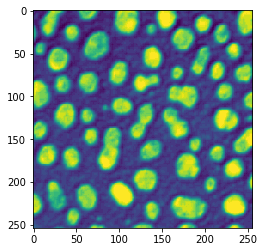

In [4]:
ij.py.show(blobs)

In [5]:
def print_stack_trace(e):
    #print(e.classname + ': ' + str(e))
    print('\n\tat '.join(e.stacktrace))

# Display full Java stack trace.
try:
    IJ.run(blobs, "Clear Outside", "");
except jnius.JavaException as exc:
    print_stack_trace(exc)

java.lang.RuntimeException: Macro canceled
	at ij.IJ.abort(IJ.java:2241)
	at ij.IJ.testAbort(IJ.java:378)
	at ij.IJ.run(IJ.java:311)
	at ij.IJ.run(IJ.java:364)


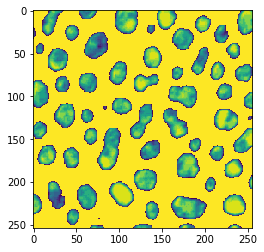

In [6]:
# Threshold, then clear the background.
try:
    IJ.setAutoThreshold(blobs, "Default");
    IJ.setBackgroundColor(0, 0, 0);
    IJ.run(blobs, "Create Selection", "");
    IJ.run(blobs, "Clear Outside", "");
    ij.py.show(blobs)
except jnius.JavaException as exc:
    print_stack_trace(exc)


In [7]:
blobs_ij2 = ij.py.to_dataset(blobs)
blobs32 = ij.op().run('convert.float32', blobs_ij2)
blobs32

<net.imagej.DefaultDataset at 0x13bd9c830 jclass=net/imagej/DefaultDataset jself=<LocalRef obj=0x7fbecfd23cb8 at 0x1371398b0>>

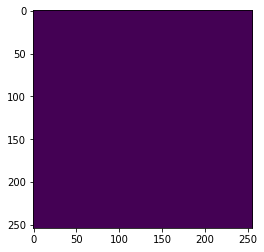

In [8]:
import numpy
filtered = numpy.zeros(ij.py.dims(blobs), dtype=float)

script = """
#@ OpService ops
#@ Dataset image
#@both net.imglib2.RandomAccessibleInterval filtered
ops.filter().frangiVesselness(filtered, image, [1, 1], 20)
"""
args = {
    "image": blobs32,
    "filtered": ij.py.to_java(filtered)
}
ij.py.run_script('groovy', script, args)
ij.py.show(filtered)

In [9]:
# Is there an active dataset?
d = ij.imageDisplay().getActiveDataset()
d is None

False

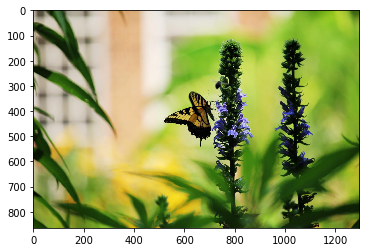

In [10]:
# Open an image.
from skimage import io
url = 'https://github.com/hanslovsky/imglyb-examples/raw/master/resources/butterfly_small.jpg'
img = io.imread(url)
ij.py.show(img)

In [11]:
# Convert numpy image to ImgLib2 via unified conversion mechanism.
jimg = ij.py.to_java(img)
jimg

<net/imglib2/python/ReferenceGuardingRandomAccessibleInterval at 0x141338db0 jclass=net/imglib2/python/ReferenceGuardingRandomAccessibleInterval jself=<LocalRef obj=0x7fbecfc9c4b0 at 0x13ce947b0>>

In [12]:
# Is there an active image?
WindowManager = jnius.autoclass('ij.WindowManager')
activeImp = WindowManager.getCurrentImage()
activeImp is None

False